# McsPyDataTools IMU Tutorial<a id='Top'></a>

- <a href='#Gyrosocope Data'>Gyroscope Data</a>
- <a href='#Accelerometer Data'>Accelerometer Data</a>
- <a href='#6DoF-Estimation'>Combined 6-DoF Data</a>

Tutorial to show the handling of IMU data collected from an MCS Headstage wearing an *Inertial Measurement Unit*

Load module and the data file:

In [54]:
import sys
sys.path.append(r"../McsPyDataTools")
sys.executable

'C:\\Users\\dietzsch\\AppData\\Local\\conda\\conda\\envs\\kinematics\\python.exe'

In [55]:
# These are the imports of the McsData module
import McsPy.McsData
import McsPy.functions_info
from McsPy import ureg, Q_

# matplotlib.pyplot will be used in these examples to generate the plots visualizing the data
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.widgets import Slider
# These adjustments only need to be made so that the plot gets displayed inside the notebook
%matplotlib inline
# %config InlineBackend.figure_formats = {'png', 'retina'}

# numpy is numpy ...
import numpy as np
import McsPy.functions_info as fi

Check the content of the data file folder:

In [56]:
fi.print_dir_file_info(".\\TestData")

invalid literal for int() with base 10: ''
File                                             Date                   Anal.    Ev    Seg.    TS    FS
-----------------------------------------------  -------------------  -------  ----  ------  ----  ----
2014-07-09T10-17-35W8 Standard all 500 Hz.h5     2014-07-09 10:17:35        3     1       1     1     0
2017-10-11T13-39-47McsRecording_X981_AccGyro.h5  2017-10-11 13:39:47        6     0       0     0     0
AnalogSegmentTimestamp.h5                        2014-07-25 11:30:56        1     0       1     1     0
AverageEvent.h5                                  2015-04-02 16:04:26        0     0       1     0     0
CMOSTestRec.h5                                   2014-11-04 10:24:32        0     0       0     0     1
Retina.h5                                        2016-05-17 15:34:05        0     0       0     0     1


Check what's inside the file:

In [57]:
acc_gyro_raw_data_file_path = ".\\TestData\\2017-10-11T13-39-47McsRecording_X981_AccGyro.h5"
fi.print_file_info(acc_gyro_raw_data_file_path)


.\TestData\2017-10-11T13-39-47McsRecording_X981_AccGyro.h5

Date                 Program                     Version
-------------------  --------------------------  ------------
2017-10-11 13:39:47  Multi Channel Experimenter  2.6.90.17257

Type    Stream                                         # ch
------  -------------------------------------------  ------
Analog  Data Acquisition (1) Quality Sideband Data1       1
Analog  Data Acquisition (1) Electrode Raw Data1         32
Analog  Data Acquisition (1) Analog Data1                 1
Analog  Data Acquisition (1) Digital Data1                1
Analog  Data Acquisition (1) Gyroscope Data1              3
Analog  Data Acquisition (1) Accelerometer Data1          3


Load the file in silent mode:

In [58]:
McsPy.McsData.VERBOSE = False
raw_data = McsPy.McsData.RawData(acc_gyro_raw_data_file_path)

## Gyroscope Data<a id='Gyroscope Data'></a>

In [59]:
gyro_channel = raw_data.recordings[0].analog_streams[4]
print('Channel IDs: %s' % gyro_channel.channel_infos.keys())

Channel IDs: dict_keys([148, 149, 150])


In [60]:
gyro = np.transpose(gyro_channel.channel_data)
gyro.shape

(16400, 3)

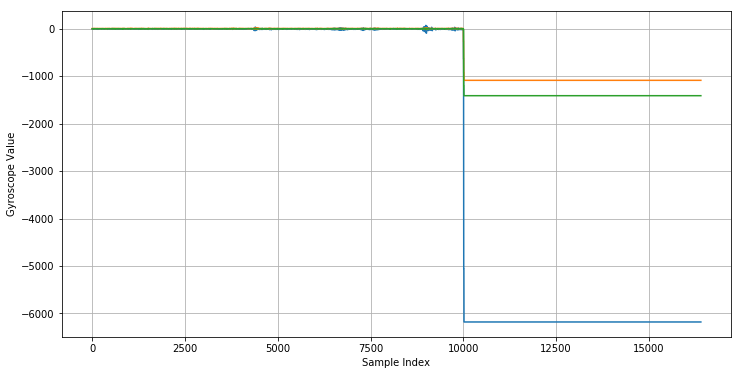

In [61]:
plt.figure(figsize=(12,6))
plt.plot(gyro)
#plt.title('Signal for Wireless (Simulation) / Raw ADC-Values (%s)' % analog_stream_0.label)
plt.xlabel('Sample Index')
plt.ylabel('Gyroscope Value')
plt.grid()

plt.show()

Cutout invalid data parts:

In [62]:
gyro = gyro[0:10000,0:3]
gyro.shape

(10000, 3)

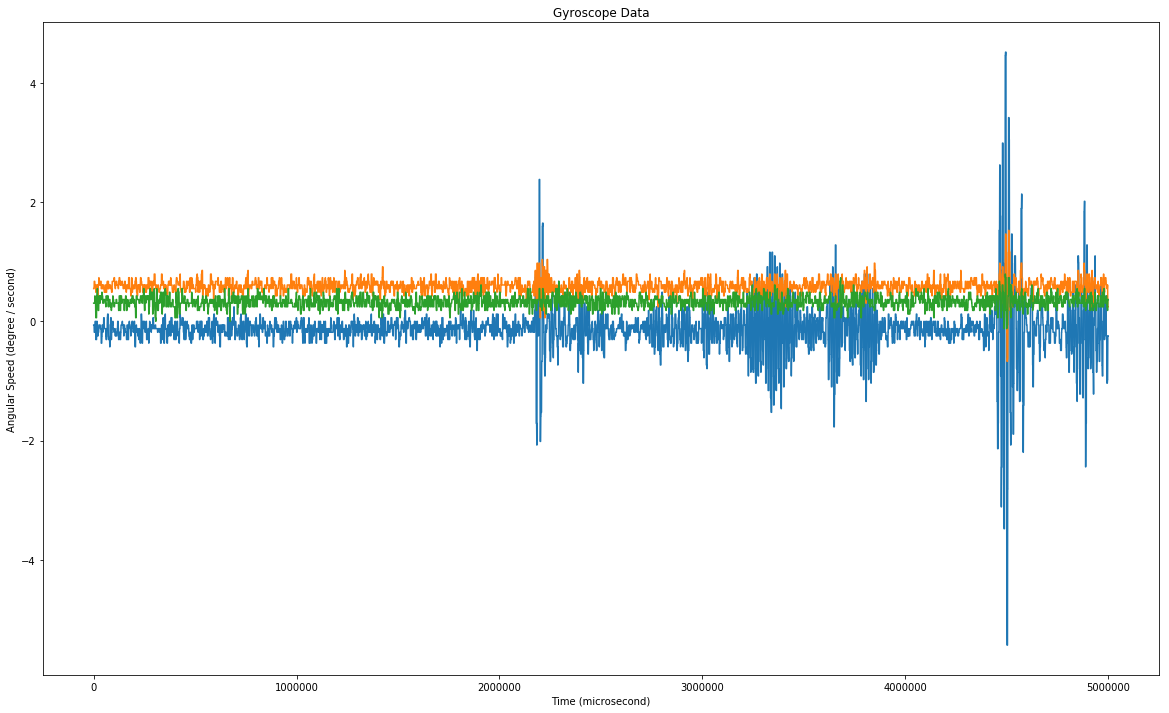

In [63]:
time = gyro_channel.get_channel_sample_timestamps(148,0,10000)
gyro_x = gyro_channel.get_channel_in_range(148,0,10000)
gyro_y = gyro_channel.get_channel_in_range(149,0,10000)
gyro_z = gyro_channel.get_channel_in_range(150,0,10000)
plt.figure(figsize=(20,12))
plt.plot(time[0], gyro_x[0])
plt.plot(time[0], gyro_y[0])
plt.plot(time[0], gyro_z[0])
plt.xlabel('Time (%s)' % time[1])
plt.ylabel('Angular Speed (%s)' % gyro_x[1])
plt.title('Gyroscope Data')
plt.show()

## Accelerometer Data<a id='Accelerometer Data'></a>

In [64]:
acc_channel = raw_data.recordings[0].analog_streams[5]
print('Channel IDs: %s' % acc_channel.channel_infos.keys())

Channel IDs: dict_keys([160, 161, 162])


In [65]:
acc = np.transpose(acc_channel.channel_data)
acc.shape

(16400, 3)

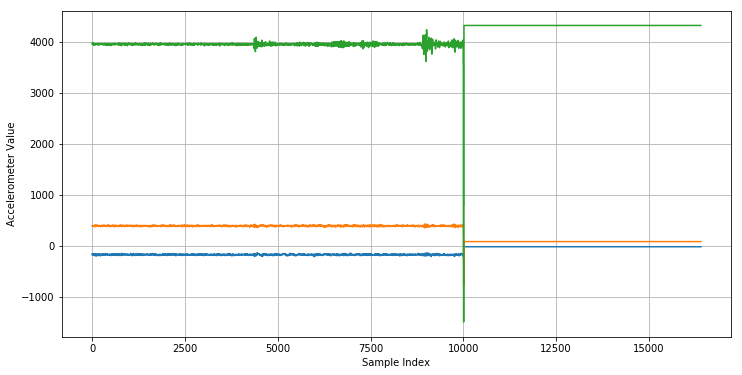

In [66]:
plt.figure(figsize=(12,6))
plt.plot(acc)
#plt.title('Signal for Wireless (Simulation) / Raw ADC-Values (%s)' % analog_stream_0.label)
plt.xlabel('Sample Index')
plt.ylabel('Accelerometer Value')
plt.grid()

plt.show()

Cutout invalid data parts:

In [67]:
acc = acc[0:10000,0:3]
acc.shape

(10000, 3)

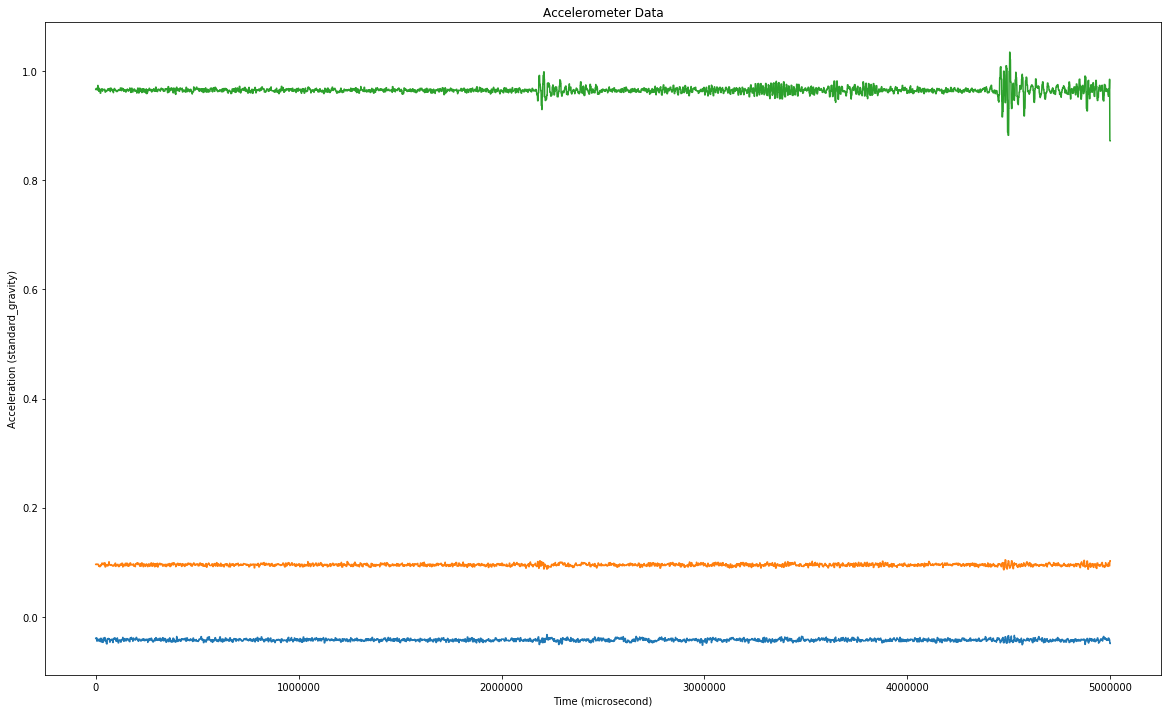

In [68]:
time = acc_channel.get_channel_sample_timestamps(160,0,10000)
acc_x = acc_channel.get_channel_in_range(160,0,10000)
acc_y = acc_channel.get_channel_in_range(161,0,10000)
acc_z = acc_channel.get_channel_in_range(162,0,10000)
plt.figure(figsize=(20,12))
plt.plot(time[0], acc_x[0])
plt.plot(time[0], acc_y[0])
plt.plot(time[0], acc_z[0])
plt.xlabel('Time (%s)' % time[1])
plt.ylabel('Acceleration (%s)' % acc_x[1])
plt.title('Accelerometer Data')
plt.show()

## Combined 6-DoF Data<a id='6DoF-Estimation'></a>

In [69]:
import skinematics as skin
from skinematics.imus import IMU_Base

from scipy import constants # for "g"

from mpl_toolkits.mplot3d import Axes3D


Load data and separate values from unit:

In [70]:
time, time_unit = gyro_channel.get_channel_sample_timestamps(148,0,10000)
gyro_x, gyro_x_unit = gyro_channel.get_channel_in_range(148,0,10000)
gyro_y, gyro_y_unit = gyro_channel.get_channel_in_range(149,0,10000)
gyro_z, gyro_z_unit = gyro_channel.get_channel_in_range(150,0,10000)

time, time_unit = acc_channel.get_channel_sample_timestamps(160,0,10000)
acc_x, acc_x_unit = acc_channel.get_channel_in_range(160,0,10000)
acc_y, acc_y_unit = acc_channel.get_channel_in_range(161,0,10000)
acc_z, acc_z_unit = acc_channel.get_channel_in_range(162,0,10000)

Define a new class for our data - derived from *IMU_Base* class in *scikit-kinematics*:

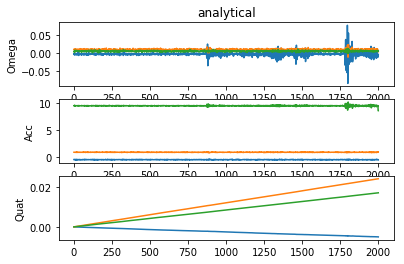

In [71]:
class McsIMU(IMU_Base):
    """Concrete class based on abstract base class IMU_Base """    
    
    def get_data(self, in_file, in_data):
        '''Get the sampling rate, as well as the recorded data,
        and assign them to the corresponding attributes of "self".
        
        Parameters
        ----------
        in_file : string
                Filename of the data-file
        in_data : 
                Sampling rate (has to be provided!!)
        
        Assigns
        -------
        - rate : rate
        - acc : acceleration
        - omega : angular_velocity
        '''
        
        # The sampling rate has to be provided externally
        rate = in_data['rate']
            
        # Get the data, and label them
        data.columns = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'mag_x', 'mag_y', 'mag_z', 'taccgyr', 'tmag']
            
        # Set the conversion factors by hand, and apply them
        #conversions = {}
        #conversions['time'] = 1/1000000
        #conversions['acc'] = 9.81
        #conversions['gyr'] = np.pi/180   
        #data[:,:3] *= conversions['acc']
        #data[:,3:6] *= conversions['gyr']
        #data[:,6] *= conversions['time']
            
        returnValues = [rate]
        
        # Extract the columns that you want, by name
        #paramList=['acc', 'gyr', 'mag']
        #for param in paramList:
        #    Expression = param + '*'
        #    returnValues.append(data_interp.filter(regex=Expression).values)
        returnValues.append(in_data['acc'])
        returnValues.append(in_data['gyro'])
        self._set_info(*returnValues)

# Set the conversion factors by hand, and apply them
conversions = {}
conversions['time'] = 1/1000000
conversions['acc'] = constants.g
conversions['gyr'] = np.pi/180

acc = np.column_stack((acc_x, acc_y, acc_z)) * conversions['acc']
gyro = np.column_stack((gyro_x, gyro_y, gyro_z)) * conversions['gyr']
time_second = time * conversions['time']

acc_sub = acc[::5,:].copy()
gyro_sub = gyro[::5,:].copy()

initial_orientation = np.array([[1,0,0],
                                [0,1,0],
                                [0,0,1]])
in_data = {"rate" : 2000, "acc" : acc, "omega" : gyro, "mag": None}
in_data_subsampled = {"rate" : 400, "acc" : acc_sub, "omega" : gyro_sub, "mag": None}
#mcs_imu = McsIMU(in_file = None, R_init = initial_orientation, in_data = in_data)
mcs_imu = McsIMU(in_file = None, R_init = initial_orientation, in_data = in_data_subsampled)
# mcs_imu.get_data(None, {'rate': 2000, 'acc': acc, 'gyro': gyro})

def show_result(imu_data):
        fig, axs = plt.subplots(3,1)
        axs[0].plot(imu_data.omega)
        axs[0].set_ylabel('Omega')
        axs[0].set_title(imu_data.q_type)
        axs[1].plot(imu_data.acc)
        axs[1].set_ylabel('Acc')
        axs[2].plot(imu_data.quat[:,1:])
        axs[2].set_ylabel('Quat')
        plt.show()

show_result(mcs_imu)

<a href='#Top'>Back to index</a>

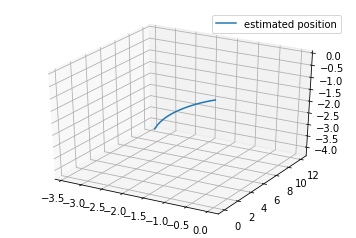

In [72]:
mcs_imu.q_type = 'analytical'
mcs_imu.calc_position()
pos_data = mcs_imu.pos

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(pos_data[:,0], pos_data[:,1], pos_data[:,2], label='estimated position')
ax.legend()

plt.show()